In [130]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns

In [117]:
data = pd.read_csv('CrowdstormingDataJuly1st.csv')
data

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177,72,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712,0.000564,0.396000,750,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179,82,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40,0.010875,-0.204082,49,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181,79,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785,0.000229,0.588297,1897,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191,87,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785,0.000229,0.588297,1897,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172,70,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785,0.000229,0.588297,1897,0.001002
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182,71,Center Back,1,0,...,0.00,4,4,LUX,0.325185,127,0.003297,0.538462,130,0.013752
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187,80,Left Fullback,1,1,...,0.25,4,4,LUX,0.325185,127,0.003297,0.538462,130,0.013752
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180,68,Defensive Midfielder,1,0,...,1.00,4,4,LUX,0.325185,127,0.003297,0.538462,130,0.013752
8,anders-lindegaard,Anders Lindegaard,Manchester United,England,13.04.1984,193,80,Goalkeeper,1,0,...,0.25,4,4,LUX,0.325185,127,0.003297,0.538462,130,0.013752
9,andreas-beck,Andreas Beck,1899 Hoffenheim,Germany,13.03.1987,180,70,Right Fullback,1,1,...,0.00,4,4,LUX,0.325185,127,0.003297,0.538462,130,0.013752


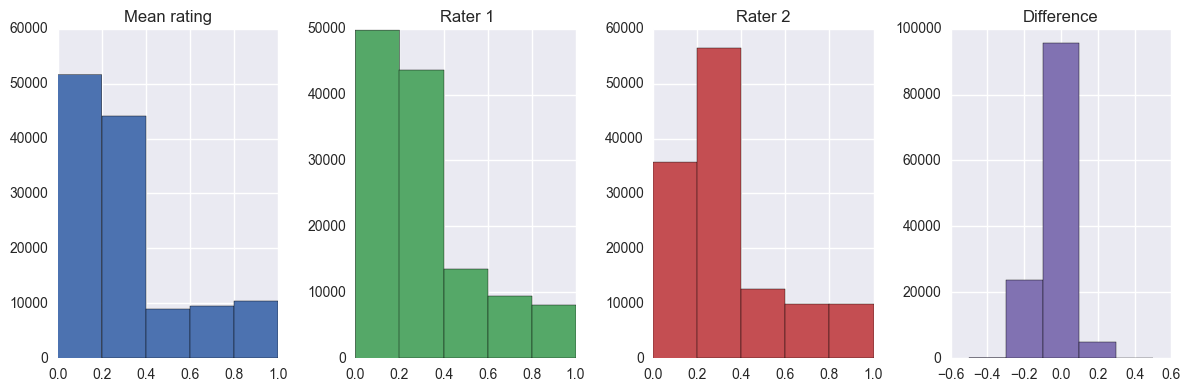

In [140]:
f, axe = plt.subplots(1, 4, figsize=(12, 4))

mean_skin = ((data['rater1'] + data['rater2']) /2).dropna()

axe[0].hist(mean_skin, bins=5, range= (0, 1), color = sns.color_palette()[0])
axe[0].set_title("Mean rating")

axe[1].hist(data['rater1'].dropna(), bins=5, range= (0,1), color=sns.color_palette()[1])
axe[1].set_title("Rater 1")

axe[2].hist(data['rater2'].dropna(), bins=5, range =(0, 1), color = sns.color_palette()[2])
axe[2].set_title('Rater 2')

axe[3].hist((data['rater1'] - data['rater2']).dropna(), bins=5, range = (-0.5, 0.5), color = sns.color_palette()[3])
axe[3].set_title("Difference")
f.tight_layout()

There seems to be some disagreement between the two rater for the lower end of the skin color spectrum. This difference of rating could probably be reduced by having more raters for each player.

Disaggregating the data
======================

We now proceed to disaggregate the data as the guys from OSF did. The idea is to get a row per interaction (game) between a player and a referee instead of only one with a high games count.

In [ ]:
refs = pd.unique(data['refNum'].values.ravel())

data['refCount'] = 0

for r in refs:
    data['refCount'][data['refNum'] == r] = len(data[data['refNum'] == r]) # Adding a new colum couting the number of occurence of this ref to each dyad 
    
j = 0 # J will be the index in the resulting dataframe
result = [0 for _ in range(sum(data['games']))]

for _, row in data.iterrows():
    g = row['games']
    reds = row['redCards']
    yell = row['yellowReds']
    
    for _ in range(g): # Now we create one row per game
        row['reds'] = 1 if (reds - _) > 0 else 0
        row['yellow'] = 1 if (yell - _) > 0 else 0
        rowcopy = list(row)
        result[j] = rowcopy
        j += 1
        
        if j % 10 == 0:
            print("Done " + j + " rows!")
    
pd.DataFrame(result, colnames = data.colnames).to_csv('disagg.csv', index=False)

/usr/lib64/python3.4/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Cleaning up
===========
Now that w'eve disaggregated the data as one row per meeting between a referee and a player, we proceed to fix the problem spotted by the guys at osf.io, namely the fact that the players' entire career are included in the dataset. We proceed to count the number of relation between each referee and any player and remove it if it is less than 22 since that means that refered a game outside the scope of our data.

In [5]:
# In retrospect I don't really know why I did the disaggregation because we don't really about referees at all ....
df = pd.read_csv('disagg.csv')
allRefs = df['refNum'].value_counts()
validRefs = allRefs[allRefs > 21] # Only keep referee which appear more than 21 times

goodRefs = df[df['refNum'].isin(validRefs)]
goodRefs.sample(5)

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,refCount,reds,yellow
74958,cesc-fabregas,Cesc Fàbregas,FC Barcelona,Spain,04.05.1987,179,75,Center Midfielder,6,6,...,ESP,0.369894,1785,0.000229,0.588297,1897,0.001002,556,0,0
232664,stephen-warnock,Stephen Warnock,Bolton Wanderers,England,12.12.1981,183,77,Left Fullback,10,3,...,ENGL,0.326690,44791,0.000010,0.356446,46916,0.000037,599,0,0
300265,pepe-reina,Pepe Reina,Liverpool FC,England,31.08.1982,188,92,Goalkeeper,13,9,...,ENGL,0.326690,44791,0.000010,0.356446,46916,0.000037,411,0,1
91976,stilian-petrov,Stilian Petrov,Aston Villa,England,05.07.1979,180,77,Center Midfielder,1,0,...,SCOT,0.326690,44791,0.000010,0.356446,46916,0.000037,12,0,0
52124,geoffrey-dernis,Geoffrey Dernis,Stade Brest,France,24.12.1980,171,66,Left Midfielder,2,1,...,FRA,0.334684,2882,0.000151,0.336101,3011,0.000586,440,0,0


In [263]:
# We now have to combine both ratings of skin color into to have only one response variable and simplify the process
# Really don't know why we care about disaggregation...
df = pd.read_csv('CrowdstormingDataJuly1st.csv')

total = len(df)

print("%d players known" % total)

df['skintone'] = (df['rater1'] + df['rater2']) / 2
del df['rater1']
del df['rater2']

# We then need to remove players for which at least one the skin rating is NaN since we can't train the classifier with those
cleaned = df.dropna(axis=0, subset=['skintone'])

print("Removed %d invalid players" % (total - len(cleaned)))

146028 players known
Removed 21407 invalid players


There might be other features which are NaN left in the set let's see what they are.

In [264]:
for c in cleaned.columns:
    print(c + ": " + str(len(cleaned[cleaned[c].isnull()])))

playerShort: 0
player: 0
club: 0
leagueCountry: 0
birthday: 0
height: 46
weight: 753
position: 8461
games: 0
victories: 0
ties: 0
defeats: 0
goals: 0
yellowCards: 0
yellowReds: 0
redCards: 0
photoID: 0
refNum: 0
refCountry: 0
Alpha_3: 1
meanIAT: 153
nIAT: 153
seIAT: 153
meanExp: 153
nExp: 153
seExp: 153
skintone: 0


We notice there are a lot of players with no position but hopefully a smart coach will not put a player at a certain position based on his skin color but rather based on his skill ;)

We also notice that the same set of players don't have the \*IAT and \*Exp variables set! This makes senses since those are collected per country. However considering the size of our dataset there are very few entries with no IAT and Exp so we can drop those without much concern!

In [265]:
cleaned = cleaned.dropna(axis=0, subset=['meanIAT'])

assert cleaned[cleaned['nExp'].isnull()].empty # This confirms that the *IAT and *Exp are NaN for the same set of players

For the weight and height features it makes sense to assume that the players have a rather similar build because of playing footbal professionnaly (essentially the same diet and exercise schedule). So we can approximate the NaN values with the mean weight and mean height respectively.

In [266]:
nweight_idx = cleaned[cleaned['weight'].isnull() & cleaned['height'].notnull()].index # We can't know a player's weight if we don't have his height
nheight_idx = cleaned[cleaned['height'].isnull() & cleaned['weight'].notnull()].index # And vice versa

In [275]:
for idx in nweight_idx:
    if idx > len(cleaned):
        continue
    sk = cleaned.iloc[idx].skintone
    mweight_for_sk = cleaned['weight'][(cleaned['skintone'] == sk) & (cleaned['height'] == cleaned.iloc[idx].height)].mean()
    cleaned.set_value(idx, 'weight', mweight_for_sk)
    
for idx in nheight_idx:
    sk = cleaned.iloc[idx].skintone
    mheight_for_sk  = cleaned['height'][(cleaned['skintone'] == sk) & (cleaned['weight'] == cleaned.iloc[idx].weight)].mean()
    cleaned.set_value(idx, 'height', mheight_for_sk)
    
print(str(len(cleaned[cleaned['weight'].isnull()])) + ", " + str(len(cleaned[cleaned['height'].isnull()])))

# Now we remove these entries from the same since they are useless!
cleaned = cleaned.dropna(subset=['height', 'weight'], axis=0)

print(str(len(cleaned)) + " players in the dataset")

assert cleaned[cleaned['height'].isnull() | cleaned['weight'].isnull()].empty

0, 0
124321 players in the dataset


We are now reasonably confident that we have a cleaned dataset and we proceed to the actual classification task.

Classification
============

Dropping useless features
---------------------------------------------------------

We now delete a few features that seems completely unrelated to a player's skin color

In [268]:
# Now dropping features that are useless for our classification

dropping = ['player', 'position', 'birthday', 'photoID', 'nExp', 'seExp', 'seIAT', 'refNum', 'nIAT']
r = cleaned.copy()

for c in dropping:
        r = r.drop(c, axis=1)
        
# Hopefully players play a certain role based on their skill ...
# The referee certainly has nothing to do with the player's skin color :X
# More black people are born on certain date ? :D
# The name of the photo, seriously? 
# The standard error and count for IAT and Exp are based on countries not on the players themselves so we can remove them as well
r = r.groupby('playerShort').agg('first') # Only keep one entry per player

r.columns

Index(['club', 'leagueCountry', 'height', 'weight', 'games', 'victories',
       'ties', 'defeats', 'goals', 'yellowCards', 'yellowReds', 'redCards',
       'refCountry', 'Alpha_3', 'meanIAT', 'meanExp', 'skintone'],
      dtype='object')

Label encoding
----------------------
Since scikit-learn only supports numerical data we need to create a mapping between our textual data and a numerical represtation. We do this using the LabelEncoder from scikit-learn. See [here](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)

In [295]:
from sklearn.preprocessing import LabelEncoder

r.dropna(inplace=True)
features = r.drop('skintone', axis=1) # The features df is the same but without the response variable
y = r['skintone']

for f in features.columns:
    encoder = LabelEncoder()
    labels = encoder.fit_transform(features[f])
    features[f] = labels
    
labels = LabelEncoder().fit_transform(y)

print(str(len(np.unique(r['skintone']))) + " unique skintone values in the set")

9 unique skintone values in the set


0.125

Random Forest Classifier training
--------------------------------------

In [290]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3)

model = RandomForestClassifier()

clf = model.fit(X_train, y_train)

In [291]:
clf.score(X_test, y_test)

0.24421052631578946

In [278]:
from sklearn.cross_validation import cross_val_score

score = cross_val_score(clf, X_test, y_test, cv=9)

print("Accuracy: %f with std of -+ %0.5f" % (score.mean(), score.std()*2))

Accuracy: 0.311946 with std of -+ 0.10894


Without much tuning it seems our RandomForestClassifier is almost 3 times more efficient than a random choice. We could also see if the errors fall in the class of skin color just below or just above (since even humans can't seem to agree on those :) )

Learning curve
------------------------

In [293]:
from sklearn.learning_curve import learning_curve

train_score, valid_score = learning_curve(clf, features,  y, train_sizes=[50, 80, 110])

ValueError: Unknown label type: array([[ 0.   ],
       [ 0.875],
       [ 0.   ],
       [ 0.   ],
       [ 1.   ],
       [ 0.125],
       [ 0.   ],
       [ 0.   ],
       [ 0.75 ],
       [ 0.25 ],
       [ 1.   ],
       [ 1.   ],
       [ 0.   ],
       [ 0.75 ],
       [ 0.75 ],
       [ 0.625],
       [ 0.   ],
       [ 0.   ],
       [ 0.375],
       [ 0.125],
       [ 0.   ],
       [ 0.125],
       [ 0.25 ],
       [ 0.125],
       [ 0.   ],
       [ 0.   ],
       [ 0.   ],
       [ 0.125],
       [ 0.25 ],
       [ 0.25 ],
       [ 0.125],
       [ 0.5  ],
       [ 0.25 ],
       [ 1.   ],
       [ 0.5  ],
       [ 0.   ],
       [ 0.   ],
       [ 0.125],
       [ 0.5  ],
       [ 0.5  ],
       [ 1.   ],
       [ 0.875],
       [ 0.   ],
       [ 0.75 ],
       [ 0.25 ],
       [ 0.   ],
       [ 0.25 ],
       [ 0.25 ],
       [ 0.625],
       [ 0.   ],
       [ 0.25 ],
       [ 0.   ],
       [ 0.375],
       [ 0.375],
       [ 0.   ],
       [ 0.25 ],
       [ 0.   ],
       [ 0.125],
       [ 0.25 ],
       [ 0.75 ],
       [ 1.   ],
       [ 0.75 ],
       [ 0.375],
       [ 0.125],
       [ 0.25 ],
       [ 0.25 ],
       [ 0.5  ],
       [ 0.   ],
       [ 0.125],
       [ 0.25 ],
       [ 0.125],
       [ 0.375],
       [ 0.25 ],
       [ 0.25 ],
       [ 0.   ],
       [ 0.   ],
       [ 0.5  ],
       [ 1.   ],
       [ 1.   ],
       [ 0.   ],
       [ 0.5  ],
       [ 0.125],
       [ 0.   ],
       [ 0.25 ],
       [ 0.   ],
       [ 0.   ],
       [ 0.125],
       [ 0.25 ],
       [ 0.25 ],
       [ 0.   ],
       [ 0.   ],
       [ 0.   ],
       [ 0.125],
       [ 0.375],
       [ 0.125],
       [ 0.25 ],
       [ 0.25 ],
       [ 1.   ],
       [ 0.125],
       [ 0.   ],
       [ 0.125],
       [ 0.125],
       [ 0.125],
       [ 0.125],
       [ 0.   ]])

Features importance
-------------------------

We will now examine the importance of each feature in our model and determine which one can be safely removed

In [273]:
ft = []

for idx in range(len(features.columns)):
    ft.append((clf.feature_importances_[idx], features.columns[idx]))
    
ft = sorted(ft, key=lambda s : s[0])

ft.reverse()

ft

[(0.17149675254082539, 'club'),
 (0.16312285712144542, 'height'),
 (0.15472045442022289, 'weight'),
 (0.056991348045931076, 'victories'),
 (0.055648917117327036, 'games'),
 (0.049206452082338085, 'defeats'),
 (0.047959203422978214, 'leagueCountry'),
 (0.047669389107261734, 'meanIAT'),
 (0.047211871015899978, 'Alpha_3'),
 (0.046134216908358894, 'meanExp'),
 (0.044015808547882986, 'refCountry'),
 (0.038594663042206642, 'ties'),
 (0.037546728052120323, 'yellowCards'),
 (0.03331420351554705, 'goals'),
 (0.0035966950849558596, 'yellowReds'),
 (0.0027704399746984283, 'redCards')]

We notice that the 3 most usefull features in the model are the club in which a player plays, his height and his weight. Let's try to fit a model with only those 3 features!

In [260]:
nfeatures = features[['club', 'weight', 'height']]

nX_train,  nX_test, ny_train, ny_test = train_test_split(nfeatures, labels, test_size=0.4)

forest = RandomForestClassifier()

clf = forest.fit(nX_train, ny_train)

In [261]:
clf.score(nX_test, ny_test)

0.23854660347551343

In [274]:
score = cross_val_score(clf, X_test, y_test, cv=9)

print("Accuracy: %f with std of -+ %0.2f" % (score.mean(), score.std()*2))

Accuracy: 0.300336 with std of -+ 0.12


In [262]:
f2 = features[['weight', 'height']]

nX_train, nX_test, ny_train, ny_test = train_test_split(f2, labels, test_size=0.4)

forest = RandomForestClassifier()

clf = forest.fit(nX_train, ny_train)

clf.score(nX_test, ny_test)

0.19115323854660349